# Technical Assessment
### Nuno Pedrosa

This notebook is a analysis of churn prediction in a internet shipment reselling company. 

In this business, the churn is represented by the customers that stop doing business with the company.

The data is available at https://zenodo.org/records/6608990.

I chose this dataset for the following reasons:
- Churn analysis is an extremely relevant topic in the business world and can be applied in various contexts;
- It aligns with the three points described in the technical assignment (Tabular Data, No Pre-existing Solutions, New Dataset).

The authors do not directly specify the meaning of each variable, so I conducted research on the meaning of the variables in order to perform a more well-founded analysis.

This dataset is composed by the following columns:

- user_id: anonymised costumer of the service
- platform: anonymised platform used by the costumer to buy the products of the company
- market_country: anonymised country of the costumer
- user_creation_datetime, confirmation_datetime, first_purchase_datetime, last_purchase_datetime, first_integration_datetime: specific dates of buying habits
- last_segment_recorded: represents the most recent shipment size (S (Small), M (Medium), L (Large), XL (Extra Large), Non-recurrin)
- longevity: customer longevity in days 
- total_sales, avg_sales_per_day: sales number metrics
- min_days_btwn_sales, frst_quartile_days_btwn_sales, avg_days_btwn_sales, median_days_btwn_sales, thrd_quartile_days_btwn_sales, max_days_btwn_sales: metrics of days in between sales
- min_days_btwn_sale_date, fst_quartile_days_btwn_sale_date, avg_days_btwn_sale_date, median_days_btwn_sale_date, thrd_quartile_days_btwn_sale_date: metrics of dates in between sales
- frequency: Frequency of when the customer buys something
- recency: How recently a customer has made a purchase
- month_label_count, quarter_label_count, year_label_count, historic_label_count: Various purchase counts
- month_revenue_eur, quarter_revenue_eur, year_revenue_eur, historic_revenue_eur, month_average_order_value: revenue by costumer in a time frame
- quarter_aov, year_aov, year_plat_cntry_aov, previous_year_plat_cntry_aov, historic_aov: average order value metrics
- churn_factor: recency/frequency
- status: if the costumer churned or not, this is going to be our prediction objective

In [71]:
# imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from collections import Counter
import missingno as msno


## Task 1 - Dataset Selection and Loading

In [72]:
Data = pd.read_csv('Data/ecommerce_company_client_churn_data.csv')
Data.head()

user_id                          platform  \
0  a571a717903d731460c3f8b012897aa6  4128403e5dad4f40eb5c79a92a5719c9   
1  c681dc7c20837e3ea7a0c0531e3d4eb6  4128403e5dad4f40eb5c79a92a5719c9   
2  9d8cbbb590831fb2e61b4dbefe4543d4  c44577a5b4c0036fe1ec82c04bfa87c6   
3  3ce08777163438749f3110c10b72d6be  4128403e5dad4f40eb5c79a92a5719c9   
4  36989756b0656e71577f284a7e7af62a  4128403e5dad4f40eb5c79a92a5719c9   

                     market_country   user_creation_datetime  \
0  6b681da4aa6e2f33a5f06ff660ba0e9e  2019-06-10 17:10:15 UTC   
1  64f6711e77d2ec8af8ac3292c66d2875  2019-03-12 09:52:44 UTC   
2  9a6e56e83f8d0f692203f7b4850f86ff  2019-08-30 14:04:15 UTC   
3  c097bb1538327aaf74797d23f6fcef83  2020-08-16 20:56:37 UTC   
4  c097bb1538327aaf74797d23f6fcef83  2020-04-24 08:25:17 UTC   

     confirmation_datetime  first_purchase_datetime   last_purchase_datetime  \
0  2019-06-10 17:10:15 UTC  2019-08-19 16:01:43 UTC  2021-03-06 18:21:17 UTC   
1  2019-03-12 09:52:44 UTC  2019-03-12 10:31:17 UTC  2022-04-17 15:54:31 UTC   
2  2019-08-30 14:04:15 UTC  2019-09-09 20:23:35 UTC  2022-04-15 06:28:45 UTC   
3  2020-08-16 20:56:37 UTC  2020-08-16 21:04:41 UTC  2022-04-08 08:31:15 UTC   
4  2020-04-24 08:25:17 UTC  2020-05-26 09:28:55 UTC  2022-03-14 11:43:35 UTC   

  first_integration_datetime last_segment_recorded  longevity  ...  \
0    2019-08-19 16:01:43 UTC                     S        974  ...   
1    2019-03-12 10:31:17 UTC                     S       1134  ...   
2    2019-11-26 17:34:22 UTC         Non-recurring        953  ...   
3    2020-08-16 21:04:41 UTC                     M        611  ...   
4    2020-05-26 09:28:55 UTC                     S        693  ...   

   historic_aov  csat  cs_tickets_good  cs_tickets_offered  \
0     14.455833   NaN              NaN                 NaN   
1      9.582500   NaN              NaN                 NaN   
2    129.056800   1.0              7.0                 8.0   
3     12.827273   NaN              0.0                 3.0   
4     19.607500   NaN              NaN                 NaN   

   cs_tickets_unoffered  cs_tickets_bad  customer_feedback_tickets  \
0                   NaN             NaN                        NaN   
1                   NaN             NaN                        NaN   
2                   4.0             0.0                        7.0   
3                   0.0             0.0                        0.0   
4                   NaN             NaN                        NaN   

   total_tickets  churn_factor   status  
0            NaN     20.098765  churned  
1            NaN      0.000000       ok  
2           19.0      0.716842       ok  
3            3.0      0.482529       ok  
4            NaN      1.542553       ok  

[5 rows x 51 columns]

In [73]:
print('Our Data before Data Selection:')
print('Number of rows:', len(Data))
print('Number of columns:', len(Data.columns))

Our Data before Data Selection:
Number of rows: 1000
Number of columns: 51


In [74]:
# Check for duplicate rows

duplicates = Data[Data.duplicated()]
print('Number of duplicates:', len(duplicates))

Number of duplicates: 0


No duplicated rows were found

In [75]:
# Manipulating Date information would unnecessarily complicate our analysis, so this information will be discarded.
# We also don't need the user_id

Data = Data.drop(['user_id','user_creation_datetime','confirmation_datetime','first_purchase_datetime','last_purchase_datetime','first_integration_datetime'], axis=1)

In [76]:
# NaN Data Analysis

Nan_count_columns = Data.isna().sum().to_frame().sort_values(by=[0], ascending=False)
Nan_count_columns.head(15)

0
csat                               951
previous_year_label_count          860
previous_year_revenue_eur          860
previous_year_aov                  860
total_tickets                      799
customer_feedback_tickets          799
cs_tickets_bad                     799
cs_tickets_unoffered               799
cs_tickets_offered                 799
cs_tickets_good                    799
previous_year_plat_cntry_aov        14
avg_days_btwn_sale_date              1
thrd_quartile_days_btwn_sale_date    1
median_days_btwn_sale_date           1
min_days_btwn_sale_date              1

<AxesSubplot:>

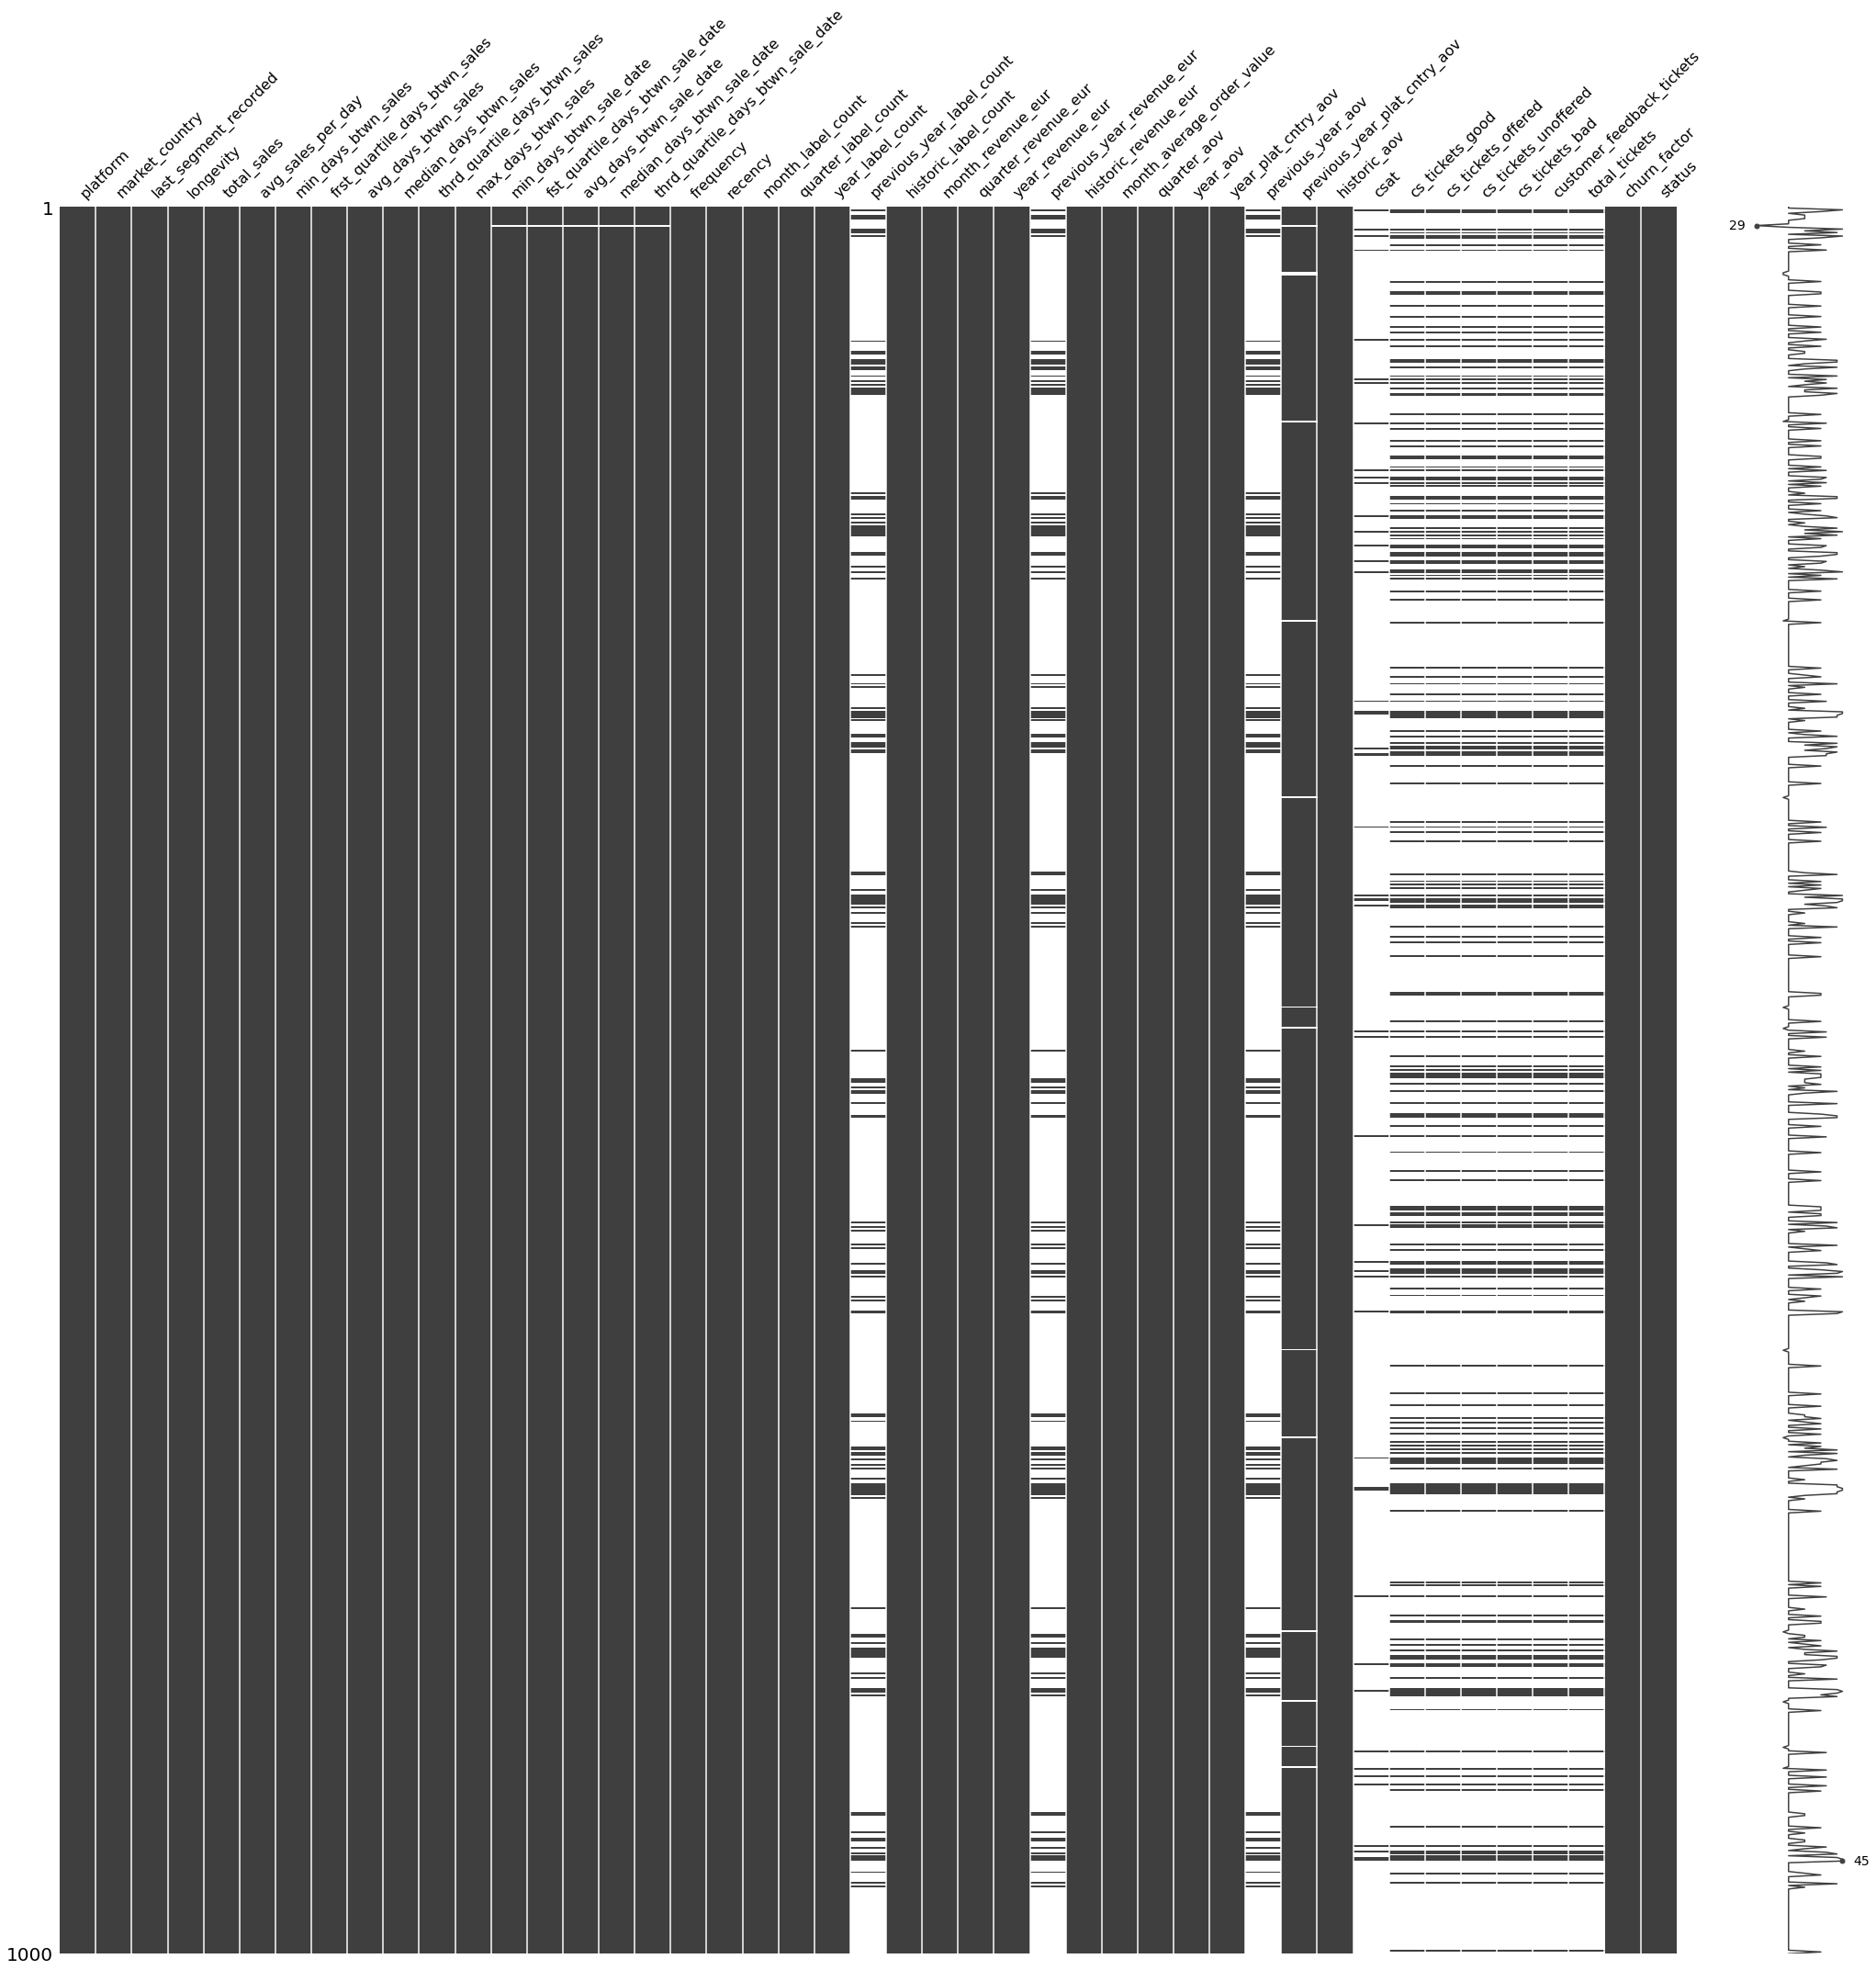

In [77]:
#matrix showing missing data
msno.matrix(Data, figsize=(35, 35))

# white represents missing data

Our dataset shows that NaN values are heavily concentrated in certain columns while being quite rare in others, with no middle ground. By a more profound analysis of the type of data we have, we can conclude that NaN data corresponds to 0. So we will substitute all NaNs to 0.

In [78]:
# Fill NaN with 0
Data = Data.fillna(0)

In this dataset, the status column is directly calculated by the churn_factor column, (factor > 4 is considered churn) wich is calculated by dividing the recency by the frequency columns. 

We want to try to predict future churn status without considering last item bought information. Why? We want to be able to predict churn based on relative custumer habits, and not just in a predetermined way by calculating the metrics relative to the last item bought.  

Because of that, there are some columns that need to be eliminated:
- last_segment_recorded
- recency
- churn_factor

In [79]:
Data = Data.drop(['last_segment_recorded','recency','churn_factor'], axis=1)

In [80]:
print('Our Data after Data Selection:')
print('Number of rows:', len(Data))
print('Number of columns:', len(Data.columns))

Our Data after Data Selection:
Number of rows: 1000
Number of columns: 42


## Task 2 - Feature Engineering

### Encoding

In [81]:
Data.dtypes

platform                              object
market_country                        object
longevity                              int64
total_sales                            int64
avg_sales_per_day                    float64
min_days_btwn_sales                    int64
frst_quartile_days_btwn_sales          int64
avg_days_btwn_sales                    int64
median_days_btwn_sales                 int64
thrd_quartile_days_btwn_sales          int64
max_days_btwn_sales                    int64
min_days_btwn_sale_date              float64
fst_quartile_days_btwn_sale_date     float64
avg_days_btwn_sale_date              float64
median_days_btwn_sale_date           float64
thrd_quartile_days_btwn_sale_date    float64
frequency                            float64
month_label_count                      int64
quarter_label_count                    int64
year_label_count                       int64
previous_year_label_count            float64
historic_label_count                   int64
month_reve

Now, we have 3 variables that aren't in a number format: platform, market_country and status.

The status column, our prediction objective, can be changed to a binary varieble (1-churned, 0-ok).

In the others, we will perform One-hot enconding to turn the data into numerical data.

In [82]:
Data['status'] = Data['status'].replace({'churned':1, 'ok':0})

# One-hot encoding function
def Enconding(Data, Column_name):

    one_hot = pd.get_dummies(Data[Column_name])
    for column in one_hot.columns:
        one_hot = one_hot.rename({column: Column_name + '_' + column}, axis=1)
    Data = Data.drop(Column_name,axis = 1)
    Data = Data.join(one_hot)
    return(Data)

Data = Enconding(Data, 'platform')
Data = Enconding(Data, 'market_country')

Data.head()

longevity  total_sales  avg_sales_per_day  min_days_btwn_sales  \
0        974           36             0.0370                    0   
1       1134           35             0.0309                    0   
2        953          568             0.5960                    0   
3        611           43             0.0704                    0   
4        693           36             0.0519                    0   

   frst_quartile_days_btwn_sales  avg_days_btwn_sales  median_days_btwn_sales  \
0                              0                   15                       3   
1                              0                   32                       3   
2                              0                    1                       0   
3                              0                   14                       1   
4                              1                   18                       6   

   thrd_quartile_days_btwn_sales  max_days_btwn_sales  \
0                             15                  144   
1                             19                  595   
2                              0                  105   
3                              7                  162   
4                             11                  376   

   min_days_btwn_sale_date  ...  platform_4128403e5dad4f40eb5c79a92a5719c9  \
0                      1.0  ...                                          1   
1                      1.0  ...                                          1   
2                      1.0  ...                                          0   
3                      1.0  ...                                          1   
4                      1.0  ...                                          1   

   platform_61e0171e3638dff765e85f0bb190ae29  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   platform_c44577a5b4c0036fe1ec82c04bfa87c6  \
0                                          0   
1                                          0   
2                                          1   
3                                          0   
4                                          0   

   market_country_3302c92812d6248fed26ac6bbd255217  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   market_country_495d8552a3bbb793a7a1a1edf5afdf74  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   market_country_49ea251b719ccdc5894c5a18ace974be  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   market_country_64f6711e77d2ec8af8ac3292c66d2875  \
0                                                0   
1                                                1   
2                                                0   
3                                                0   
4                                                0   

   market_country_6b681da4aa6e2f33a5f06ff660ba0e9e  \
0                                                1   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   market_country_9a6e56e83f8d0f692203f7b4850f86ff  \
0                               

### Train-Test Split

In [83]:
Y_data = pd.DataFrame({'status':Data['status']})
X_data = Data.drop(['status'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.33, random_state=1, stratify=Y_data)

print('Original Distribution:', Counter(Y_data['status']))
print('Train Distribution:', Counter(y_train['status']))
print('Test Distribution:', Counter(y_test['status']))

Original Distribution: Counter({0: 508, 1: 492})
Train Distribution: Counter({0: 340, 1: 330})
Test Distribution: Counter({0: 168, 1: 162})


In [84]:
X_train.head()

longevity  total_sales  avg_sales_per_day  min_days_btwn_sales  \
794        211           13             0.0616                    0   
823        454           32             0.0705                    0   
763        753            4             0.0053                    5   
714       1366          198             0.1449                    0   
388        216           16             0.0741                    0   

     frst_quartile_days_btwn_sales  avg_days_btwn_sales  \
794                              7                   16   
823                              0                   12   
763                              4                   47   
714                              0                    6   
388                              1                    3   

     median_days_btwn_sales  thrd_quartile_days_btwn_sales  \
794                      11                             24   
823                       0                             19   
763                       8                             51   
714                       2                              6   
388                       1                              5   

     max_days_btwn_sales  min_days_btwn_sale_date  ...  \
794                   51                      6.0  ...   
823                   65                      1.0  ...   
763                  171                      5.0  ...   
714                   97                      1.0  ...   
388                   11                      1.0  ...   

     platform_4128403e5dad4f40eb5c79a92a5719c9  \
794                                          1   
823                                          0   
763                                          0   
714                                          0   
388                                          1   

     platform_61e0171e3638dff765e85f0bb190ae29  \
794                                          0   
823                                          0   
763                                          1   
714                                          0   
388                                          0   

     platform_c44577a5b4c0036fe1ec82c04bfa87c6  \
794                                          0   
823                                          1   
763                                          0   
714                                          1   
388                                          0   

     market_country_3302c92812d6248fed26ac6bbd255217  \
794                                                0   
823                                                0   
763                                                0   
714                                                0   
388                                                0   

     market_country_495d8552a3bbb793a7a1a1edf5afdf74  \
794                                                0   
823                                                0   
763                                                0   
714                                                0   
388                                                0   

     market_country_49ea251b719ccdc5894c5a18ace974be  \
794                                                0   
823                                                0   
763                                                0   
714                                                0   
388                                                0   

     market_country_64f6711e77d2ec8af8ac3292c66d2875  \
794                                                0   
823                                                0   
763                                                0   
714                                                0   
388                                                0   

     market_country_6b681da4aa6e2f33a5f06ff660ba0e9e  \
794                                                0   
823                                                1   
763                                                1   
714                       

### Standardizing

We need to standerdize the data to be able to use it to construct models.In the case of Standard Scaler.

Removes the mean and scales each feature/variable to unit variance. This operation is performed feature-wise in an independent way.

- mean - 0

- standard deviation - 1

In [85]:
# Create StandardScaler instance
scaler = StandardScaler()

# Step 1: Fit the scaler on the X_train (calculates mean and std)
scaler.fit(X_train)

# Step 2: Transform the data (train and test) (applies standardization)
X_train_Scaled = scaler.transform(X_train)
X_test_Scaled = scaler.transform(X_test)


In [86]:
# transform to df

X_train_df = pd.DataFrame(X_train_Scaled, columns=X_data.columns)
X_test_df = pd.DataFrame(X_test_Scaled, columns=X_data.columns)

In [87]:
X_train_df.head()

longevity  total_sales  avg_sales_per_day  min_days_btwn_sales  \
0  -1.504444    -0.144744          -0.060750            -0.316443   
1  -0.835885    -0.092901          -0.038981            -0.316443   
2  -0.013255    -0.169301          -0.198462            -0.221411   
3   1.673274     0.360040           0.143003            -0.316443   
4  -1.490688    -0.136558          -0.030175            -0.316443   

   frst_quartile_days_btwn_sales  avg_days_btwn_sales  median_days_btwn_sales  \
0                      -0.153370            -0.518565               -0.284632   
1                      -0.394665            -0.577650               -0.476329   
2                      -0.256782            -0.060651               -0.336913   
3                      -0.394665            -0.666279               -0.441475   
4                      -0.360195            -0.710593               -0.458902   

   thrd_quartile_days_btwn_sales  max_days_btwn_sales  \
0                      -0.411565            -0.731312   
1                      -0.460090            -0.659727   
2                      -0.149530            -0.117732   
3                      -0.586255            -0.496106   
4                      -0.595960            -0.935838   

   min_days_btwn_sale_date  ...  platform_4128403e5dad4f40eb5c79a92a5719c9  \
0                -0.253128  ...                                   0.870936   
1                -0.346900  ...                                  -1.148189   
2                -0.271882  ...                                  -1.148189   
3                -0.346900  ...                                  -1.148189   
4                -0.346900  ...                                   0.870936   

   platform_61e0171e3638dff765e85f0bb190ae29  \
0                                  -0.742244   
1                                  -0.742244   
2                                   1.347266   
3                                  -0.742244   
4                                  -0.742244   

   platform_c44577a5b4c0036fe1ec82c04bfa87c6  \
0                                  -0.287038   
1                                   3.483856   
2                                  -0.287038   
3                                   3.483856   
4                                  -0.287038   

   market_country_3302c92812d6248fed26ac6bbd255217  \
0                                        -0.086711   
1                                        -0.086711   
2                                        -0.086711   
3                                        -0.086711   
4                                        -0.086711   

   market_country_495d8552a3bbb793a7a1a1edf5afdf74  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   market_country_49ea251b719ccdc5894c5a18ace974be  \
0                                        -0.175412   
1                                        -0.175412   
2                                        -0.175412   
3                                        -0.175412   
4                                        -0.175412   

   market_country_64f6711e77d2ec8af8ac3292c66d2875  \
0                                        -0.338834   
1                                        -0.338834   
2                                        -0.338834   
3                                        -0.338834   
4                                        -0.338834   

   market_country_6b681da4aa6e2f33a5f06ff660ba0e9e  \
0                                        -0.560112   
1                                         1.785357   
2                                         1.785357   
3                                         1.785357   
4                                         1.785357   

   market_country_9a6e56e83f8d0f692203f7b4850f86ff  \
0                               

### Feature Selection

Here, we will perform feature selection by removing multicollinearity in our data. Having highly correlated features in our 
X data introduces unnecessary complexity to our machine learning algorithms, which can negatively impact their performance.

In [88]:
# Correlation matrix using Pearson Correlation Coefficient Pearson Correlation Coefficient (p)

corr_matrix = X_train_df.corr()

corr_matrix.head()

longevity  total_sales  avg_sales_per_day  \
longevity                       1.000000     0.092713           0.003672   
total_sales                     0.092713     1.000000           0.952949   
avg_sales_per_day               0.003672     0.952949           1.000000   
min_days_btwn_sales             0.184982    -0.053952          -0.063335   
frst_quartile_days_btwn_sales   0.235482    -0.065668          -0.077252   

                               min_days_btwn_sales  \
longevity                                 0.184982   
total_sales                              -0.053952   
avg_sales_per_day                        -0.063335   
min_days_btwn_sales                       1.000000   
frst_quartile_days_btwn_sales             0.964296   

                               frst_quartile_days_btwn_sales  \
longevity                                           0.235482   
total_sales                                        -0.065668   
avg_sales_per_day                                  -0.077252   
min_days_btwn_sales                                 0.964296   
frst_quartile_days_btwn_sales                       1.000000   

                               avg_days_btwn_sales  median_days_btwn_sales  \
longevity                                 0.384843                0.282591   
total_sales                              -0.119015               -0.077669   
avg_sales_per_day                        -0.139530               -0.091354   
min_days_btwn_sales                       0.694801                0.910459   
frst_quartile_days_btwn_sales             0.720214                0.929935   

                               thrd_quartile_days_btwn_sales  \
longevity                                           0.344261   
total_sales                                        -0.103823   
avg_sales_per_day                                  -0.121534   
min_days_btwn_sales                                 0.700080   
frst_quartile_days_btwn_sales                       0.719299   

                               max_days_btwn_sales  min_days_btwn_sale_date  \
longevity                                 0.479994                 0.168230   
total_sales                              -0.088120                -0.058843   
avg_sales_per_day                        -0.122339                -0.068534   
min_days_btwn_sales                       0.355109                 0.969836   
frst_quartile_days_btwn_sales             0.378782                 0.932962   

                               ...  platform_4128403e5dad4f40eb5c79a92a5719c9  \
longevity                      ...                                  -0.196426   
total_sales                    ...                                   0.037675   
avg_sales_per_day              ...                                   0.047256   
min_days_btwn_sales            ...                                  -0.273754   
frst_quartile_days_btwn_sales  ...                                  -0.313949   

                               platform_61e0171e3638dff765e85f0bb190ae29  \
longevity                                                       0.222284   
total_sales                                                    -0.112967   
avg_sales_per_day                                              -0.128698   
min_days_btwn_sales                                             0.319401   
frst_quartile_days_btwn_sales                                   0.367669   

                               platform_c44577a5b4c0036fe1ec82c04bfa87c6  \
longevity                                                      -0.034310   
total_sales                                                     0.133506   
avg_sales_per_day                                               0.144003   
min_days_btwn_sales                                            -0.065158   
frst_quartile_days_btwn_sales                                  -0.077198   

                               market_country_3302c92812d6248fed26ac6bbd255217  \
longevity                                           

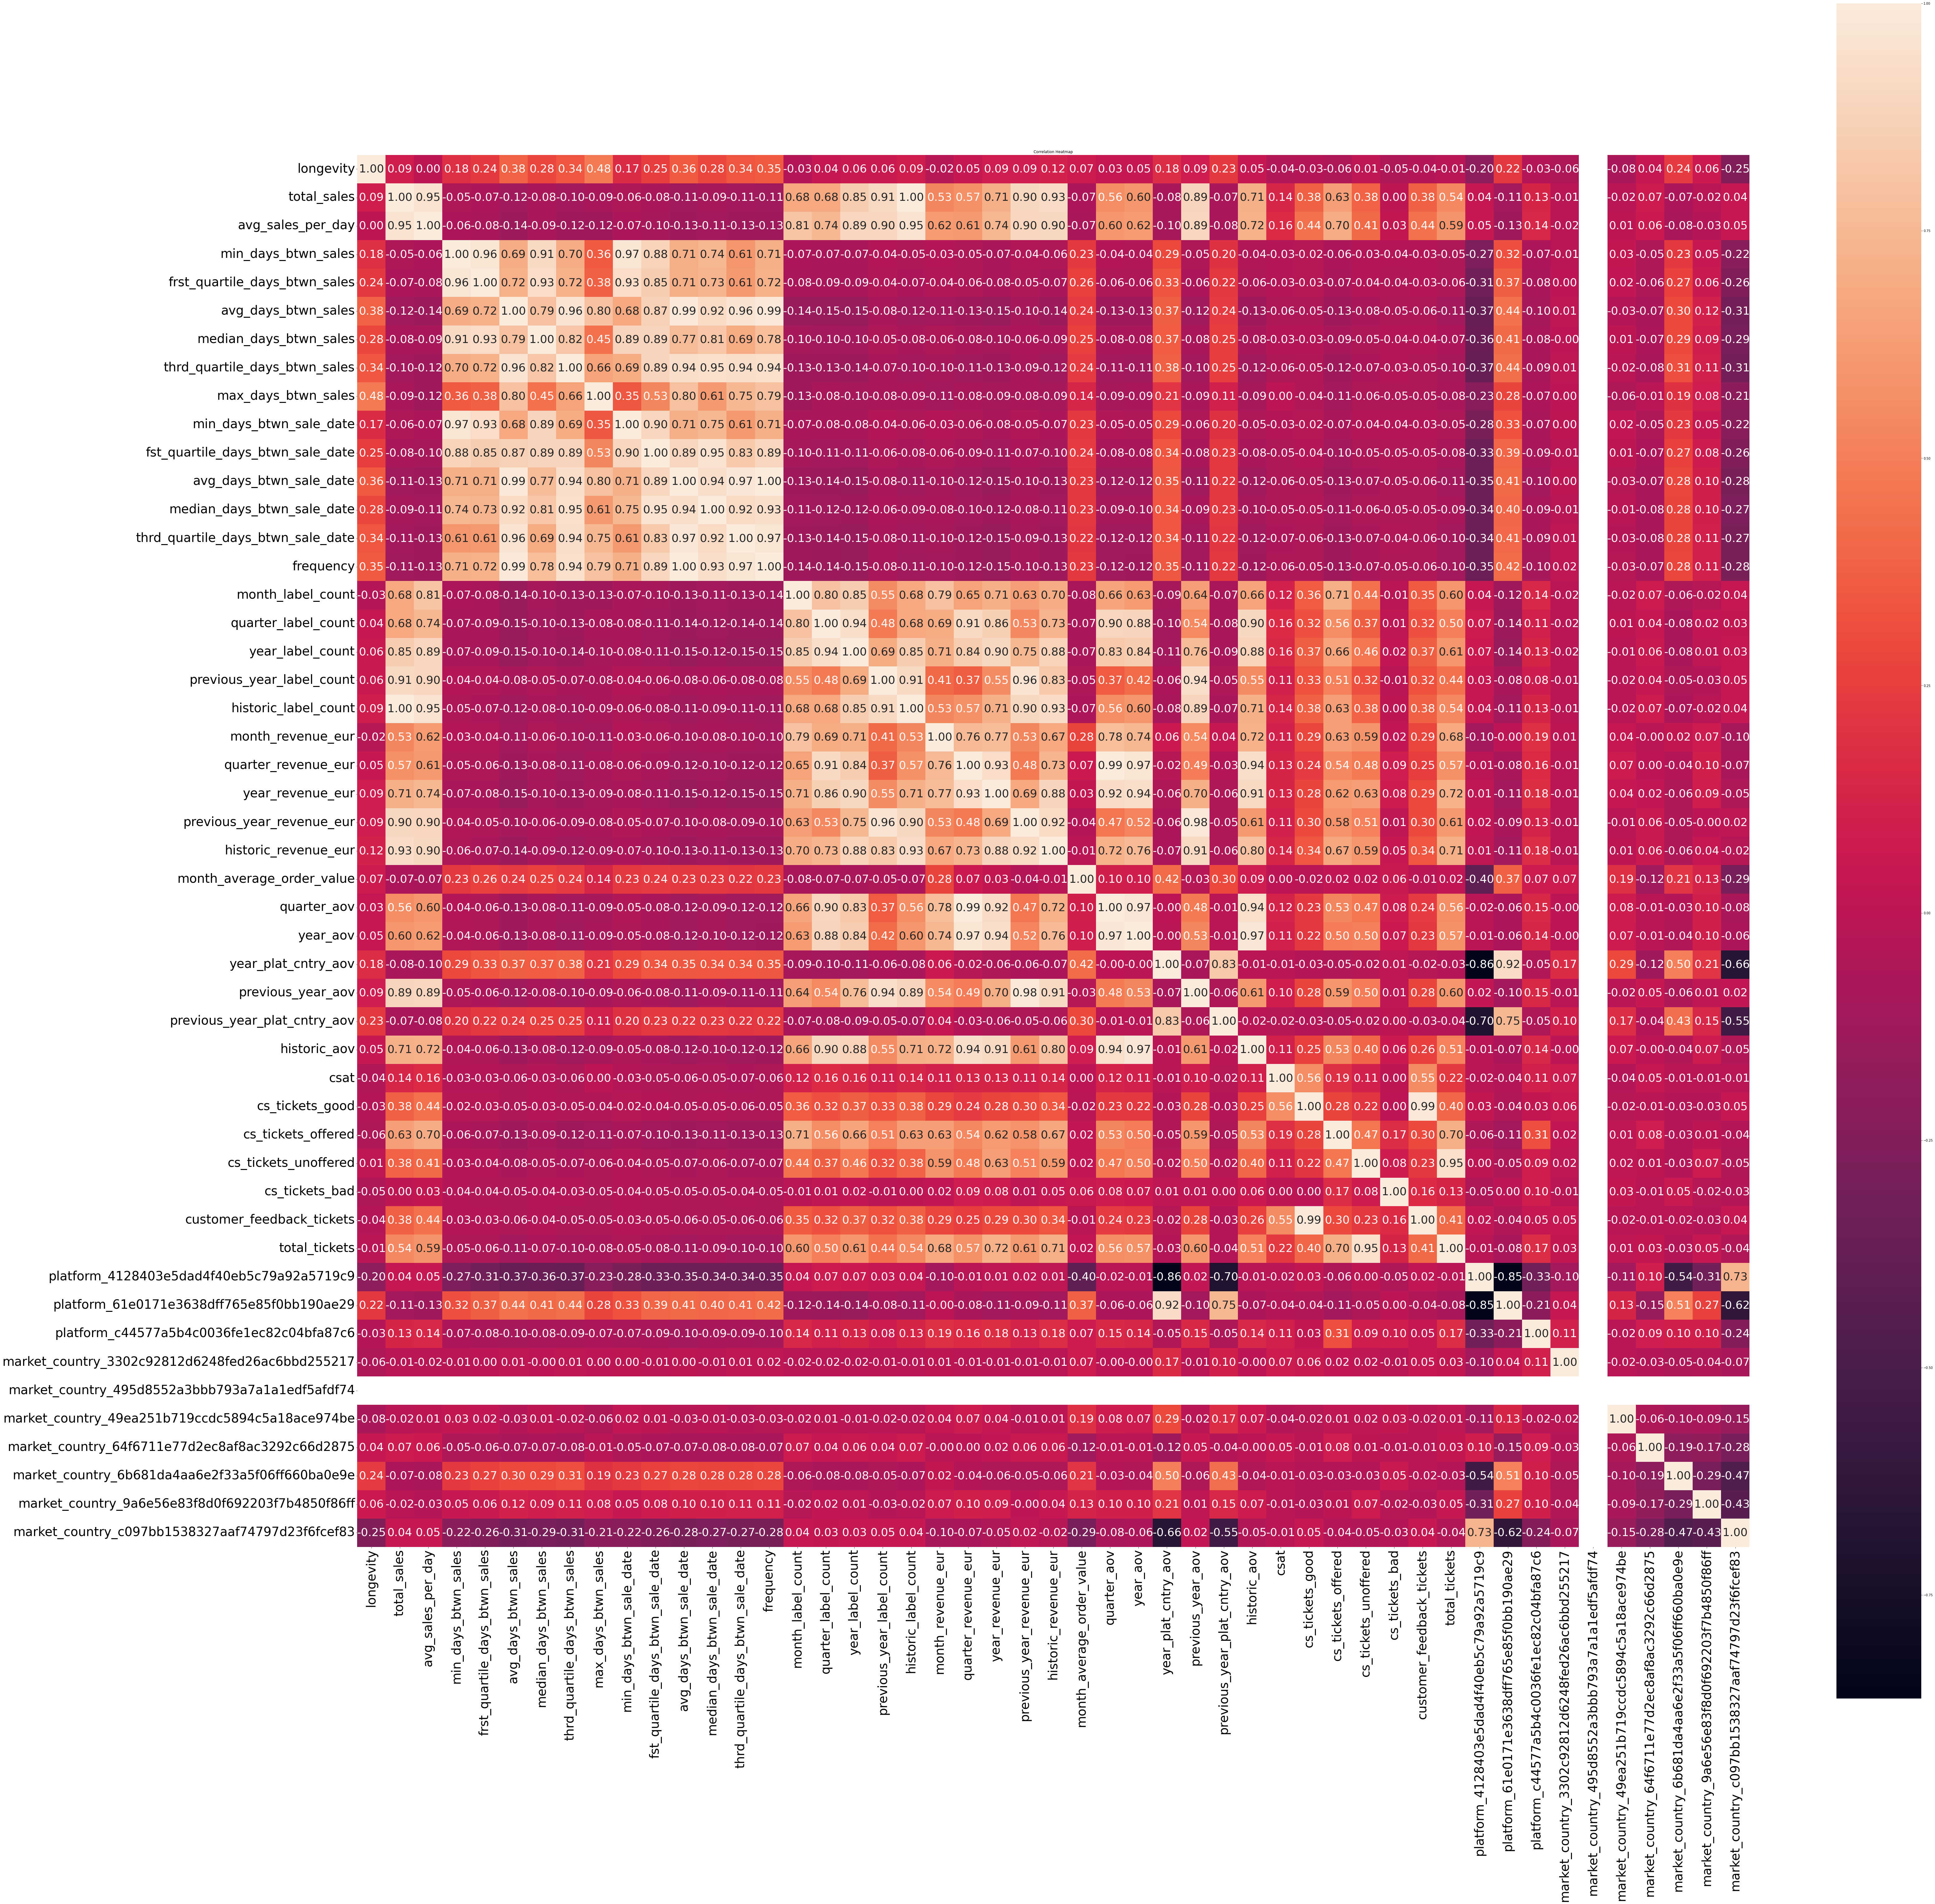

In [89]:
plt.figure(figsize=(100,100))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black',  annot_kws={"size": 36})
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)           
plt.show() 

We can see that some features are highly correlated.

To avoid multicollinearity, we will remove one of the features in pairs with correlation higher than 0.75

In [90]:
# Set threshold for high correlation
threshold = 0.8

# Get pairs with absolute correlation above the threshold (excluding self-correlation of 1.0)
high_corr_pairs = (
    corr_matrix.where((corr_matrix.abs() > threshold) & (corr_matrix.abs() < 1.0))  # Consider absolute values
    .stack()  # Convert to long format
    .reset_index()
)

high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

high_corr_pairs.head()

Feature 1                  Feature 2  Correlation
0  total_sales          avg_sales_per_day     0.952949
1  total_sales           year_label_count     0.845062
2  total_sales  previous_year_label_count     0.911897
3  total_sales  previous_year_revenue_eur     0.898839
4  total_sales       historic_revenue_eur     0.925231

In [91]:
# Eliminate one feature in each highly correlated pair
# I did not automate this process because I did not want the features to be eliminated randomly. 
# I wanted to have the ability to choose which features make the most sense to keep and which to remove.

# We also eliminate market_country_495d8552a3bbb793a7a1a1edf5afdf74 because of low amounts of data

def eliminate_features(data):

    new_data = data.drop(['total_sales',
                                  'min_days_btwn_sales',
                                  'min_days_btwn_sale_date',
                                  'median_days_btwn_sale_date', 
                                  'fst_quartile_days_btwn_sale_date',
                                  'avg_days_btwn_sale_date',
                                  'thrd_quartile_days_btwn_sale_date',
                                  'month_label_count','year_label_count',
                                  'previous_year_label_count',
                                  'historic_label_count',
                                  'quarter_label_count',
                                  'frst_quartile_days_btwn_sales',
                                  'thrd_quartile_days_btwn_sales',
                                  'frequency',
                                  'customer_feedback_tickets',
                                  'cs_tickets_unoffered',
                                  'platform_4128403e5dad4f40eb5c79a92a5719c9',
                                  'platform_61e0171e3638dff765e85f0bb190ae29',
                                  'market_country_495d8552a3bbb793a7a1a1edf5afdf74',
                                  'previous_year_plat_cntry_aov',
                                  'quarter_aov',
                                  'previous_year_aov',
                                  'historic_aov',
                                  'year_aov',
                                  'quarter_revenue_eur',
                                  'previous_year_revenue_eur',
                                  'historic_revenue_eur'], axis=1)
    
    return(new_data)

X_train_df = eliminate_features(X_train_df)
X_test_df = eliminate_features(X_test_df)

### Saving Data

Finally, we save the pre-processed data so that it can be used in the next step to feed into the models.

In [92]:
X_train_df['status'] = list(y_train['status'])
X_test_df['status'] = list(y_test['status'])

X_train_df.to_csv('Data/X_train.csv', index=False)
X_test_df.to_csv('Data/X_test.csv', index=False)

In [93]:
X_train_df.head()

longevity  avg_sales_per_day  avg_days_btwn_sales  median_days_btwn_sales  \
0  -1.504444          -0.060750            -0.518565               -0.284632   
1  -0.835885          -0.038981            -0.577650               -0.476329   
2  -0.013255          -0.198462            -0.060651               -0.336913   
3   1.673274           0.143003            -0.666279               -0.441475   
4  -1.490688          -0.030175            -0.710593               -0.458902   

   max_days_btwn_sales  month_revenue_eur  year_revenue_eur  \
0            -0.731312          -0.367085         -0.243932   
1            -0.659727           1.665316          0.111675   
2            -0.117732          -0.484745         -0.210024   
3            -0.496106           0.013753          0.021975   
4            -0.935838           0.256376         -0.180726   

   month_average_order_value  year_plat_cntry_aov      csat  ...  \
0                  -0.599229            -0.744912 -0.204484  ...   
1                  -0.246622            -0.041130 -0.204484  ...   
2                  -0.758190             1.005016 -0.204484  ...   
3                  -0.380008            -0.041130 -0.204484  ...   
4                   0.101377            -0.312458 -0.204484  ...   

   cs_tickets_bad  total_tickets  platform_c44577a5b4c0036fe1ec82c04bfa87c6  \
0       -0.121836      -0.192520                                  -0.287038   
1       -0.121836       0.213104                                   3.483856   
2       -0.121836      -0.192520                                  -0.287038   
3       -0.121836      -0.192520                                   3.483856   
4       -0.121836      -0.057312                                  -0.287038   

   market_country_3302c92812d6248fed26ac6bbd255217  \
0                                        -0.086711   
1                                        -0.086711   
2                                        -0.086711   
3                                        -0.086711   
4                                        -0.086711   

   market_country_49ea251b719ccdc5894c5a18ace974be  \
0                                        -0.175412   
1                                        -0.175412   
2                                        -0.175412   
3                                        -0.175412   
4                                        -0.175412   

   market_country_64f6711e77d2ec8af8ac3292c66d2875  \
0                                        -0.338834   
1                                        -0.338834   
2                                        -0.338834   
3                                        -0.338834   
4                                        -0.338834   

   market_country_6b681da4aa6e2f33a5f06ff660ba0e9e  \
0                                        -0.560112   
1                                         1.785357   
2                                         1.785357   
3                                         1.785357   
4                                         1.785357   

   market_country_9a6e56e83f8d0f692203f7b4850f86ff  \
0                                        -0.516276   
1                                        -0.516276   
2                                        -0.516276   
3                                        -0.516276   
4                                        -0.516276   

   market_country_c097bb1538327aaf74797d23f6fcef83  status  
0                                         1.198484       0  
1                                        -0.834388       0  
2                                        -0.834388       1  
3                                        -0.834388       0  
4                                        -0.834388       1  

[5 rows x 22 columns]